In [2]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import os.path
import requests
from shutil import unpack_archive
import matplotlib.pyplot as plt

In [3]:
dataset_link = "https://www.kaggle.com/competitions/mpbd-20232024-stock-sentiments-slam"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: martamoure
Your Kaggle Key: ··········


100%|██████████| 706k/706k [00:00<00:00, 853kB/s]


Extracting archive ./mpbd-20232024-stock-sentiments-slam/mpbd-20232024-stock-sentiments-slam.zip to ./mpbd-20232024-stock-sentiments-slam


In [4]:
data = []

file_names = ["/content/mpbd-20232024-stock-sentiments-slam/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_50Agree.txt",
              "/content/mpbd-20232024-stock-sentiments-slam/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_66Agree.txt",
              "/content/mpbd-20232024-stock-sentiments-slam/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt",
              "/content/mpbd-20232024-stock-sentiments-slam/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"]

for file_name in file_names:
    with open(file_name, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()
        for line in lines:
            text, sentiment = line.strip().split('@')
            data.append({'headline': text.strip(), 'sentiment': sentiment.strip()})

df = pd.DataFrame(data)

df

,headline,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
14775,Operating result for the 12-month period decre...,negative
14776,HELSINKI Thomson Financial - Shares in Cargote...,negative
14777,LONDON MarketWatch -- Share prices ended lower...,negative
14778,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [5]:
num_filas,num_columnas = df.shape[0],df.shape[1]
print("Número de filas:", num_filas, "Número columnas:",num_columnas)


Número de filas: 14780 Número columnas: 2


Convertimos los valores de headline a minusculas, para que tengan todos los registros el mismo formato

In [6]:
df['headline'] = df['headline'].str.lower()

Como hemos hecho una union de los cuatro txt, puede ser que tengamos registros duplicados, vamosa comprobar si se nos cumple esta casuistica:

In [7]:
duplicates = df.duplicated(subset=['headline'])

num_duplicates = duplicates.sum()

if num_duplicates > 0:
    print(f"¡Hay {num_duplicates} filas duplicadas en la columna 'headline'!")
else:
    print("No hay filas duplicadas en la columna 'headline'.")

¡Hay 9942 filas duplicadas en la columna 'headline'!


Borramos las filas duplicadas

In [8]:
df = df.drop_duplicates(subset=['headline'])

Comprobamos que las filas duplicadas se han eliminado. Inicialmente tiene 14780 registros y si eliminamos las 9942 filas duplicadas. Nos deberñias quedar 4838

In [9]:
num_filas,num_columnas = df.shape[0],df.shape[1]
print("Número de filas:", num_filas, "Número columnas:",num_columnas)

Número de filas: 4838 Número columnas: 2


## CODIFICACIÓN DE ETIQUETAS

Queremos convertir las etiquetas de sentimiento en valores numéricos para que puedan ser interpretados por nuestro modelo. Para ello, creamos una nueva columna 'sentiment_encoded' en nuestro DataFrame que contendrá las etiquetas de sentimiento codificadas en valores numéricos, donde cada categoría única de sentimiento se representa con un número entero único.

*   1 -> neutral
*   0 -> negative
*   2 -> positive










In [10]:
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

<ipython-input-10-b2a600cec3c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [11]:
df

,headline,sentiment,sentiment_encoded
0,"according to gran , the company has no plans t...",neutral,1
1,technopolis plans to develop in stages an area...,neutral,1
2,the international electronic industry company ...,negative,0
3,with the new production plant the company woul...,positive,2
4,according to the company 's updated strategy f...,positive,2
...,...,...,...
4841,london marketwatch -- share prices ended lower...,negative,0
4842,rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,1
4843,operating profit fell to eur 35.4 mn from eur ...,negative,0
4844,net sales of the paper segment decreased to eu...,negative,0


## PREPROCESAMIENTO DE TEXTO



A continuación, vamos a tokenizar la columna headline que es la que contiene las frases. Este proceso consiste en dividir el texto por cada palabra y hacer un recuento de cuantas veces aparece.


In [12]:
# Convertir la columna 'headline' del DataFrame en una lista de textos
text_list = df['headline'].tolist()

# Inicializar el Tokenizer y ajustarlo al texto
tokenizer = Tokenizer(oov_token='[UNK]', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(['<PAD>'] + text_list)

# Obtener los mapeos de palabras a índices y de índices a palabras
word_index = tokenizer.word_index

# Imprimir algunos ejemplos del mapeo
print(f'word2id: {dict(list(word_index.items())[0:4])} ...')

word2id: {'[UNK]': 1, 'the': 2, 'of': 3, 'in': 4} ...


In [13]:
x_train = tokenizer.texts_to_sequences(df['headline'])

In [14]:
num_words = len(word_index)
print(f'Número de palabras únicas en el tex_line: {num_words}')


Número de palabras únicas en el tex_line: 10133


In [15]:
sentences = [
    [word_index[w] for w in tf.keras.preprocessing.text.text_to_word_sequence(text)]
    for text in text_list
]
vocab_size = len(word_index) + 1

print(f'Corpus sentences: {len(sentences)} sentences')
print(f'Vocabulary Size: {vocab_size} words')
print(f'Sentence example:')
print(f'- {text_list[5]}')
print(f'- {sentences[5]}')

Corpus sentences: 4838 sentences
Vocabulary Size: 10134 words
Sentence example:
- financing of aspocomp 's growth aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding hdi printed circuit boards pcbs .
- [877, 3, 554, 10, 198, 554, 11, 5005, 5006, 16, 198, 349, 19, 2355, 1504, 15, 3502, 117, 1843, 5007, 1505, 1189, 1844, 2798]


## USAMOS EMBBEDING PREENTRENADO

In [16]:
EMBEDDING_DIM = 50
MAX_VOCAB_SIZE = 10133
MAX_SEQUENCE_LEN = 32

In [17]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = '/glove.6B.zip'#¡¡Subir el archivo!!

if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


In [18]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(f'tmp/glove.6B.{EMBEDDING_DIM}d.txt') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        word2vec[word] = np.fromstring(vector,'f', sep=' ')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


In [19]:
print('Creating embedding matrix with GloVe vectors... ', end='')

# Our newly created embedding: a matrix of zeros
embedding_matrix = np.zeros((MAX_VOCAB_SIZE + 2, EMBEDDING_DIM))

ko_words = 0
for word,i in word_index.items():
    if word == '[UNK]':
        # The second word is for an unknown token, in glove is 'unk'
        word = 'unk'
    if word == '<pad>':
        word = ''

    # Get the word vector and overwrite the row in its corresponding position
    word_vector = word2vec.get(word)
    if word_vector is not None:
        embedding_matrix[i] = word_vector
    else:
        ko_words += 1

print(f'done ({ko_words} words unassigned)')

Creating embedding matrix with GloVe vectors... done (1485 words unassigned)


In [20]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name='Embedding',
)

## CREAMOS PRIMERA RED NEURONAL

In [27]:
model = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 32, 50)            506750    
                                                                 
 conv1d (Conv1D)             (None, 30, 16)            2416      
                                                                 
 batch_normalization (Batch  (None, 30, 16)            64        
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 3)                 1443      
                                                                 
Total params: 510673 (1.95 MB)
Trainable params: 3891 (15.20 KB)
Non-trainable params: 506782 (1.93 MB)
__________________

Definimos las columnas X_train e Y_train

In [21]:
y_train = np.array(df['sentiment_encoded'])

In [22]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index['<pad>'],
    padding='post',
    maxlen=MAX_SEQUENCE_LEN
)

In [30]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
152/152 [==============================] - 2s 6ms/step - loss: 1.1119 - sparse_categorical_accuracy: 0.5300
Epoch 2/10
152/152 [==============================] - 1s 6ms/step - loss: 0.8170 - sparse_categorical_accuracy: 0.6391
Epoch 3/10
152/152 [==============================] - 1s 6ms/step - loss: 0.7223 - sparse_categorical_accuracy: 0.6821
Epoch 4/10
152/152 [==============================] - 1s 5ms/step - loss: 0.6666 - sparse_categorical_accuracy: 0.7042
Epoch 5/10
152/152 [==============================] - 1s 6ms/step - loss: 0.6226 - sparse_categorical_accuracy: 0.7301
Epoch 6/10
152/152 [==============================] - 1s 5ms/step - loss: 0.5796 - sparse_categorical_accuracy: 0.7456
Epoch 7/10
152/152 [==============================] - 1s 5ms/step - loss: 0.5505 - sparse_categorical_accuracy: 0.7683
Epoch 8/10
152/152 [==============================] - 1s 5ms/step - loss: 0.5204 - sparse_categorical_accuracy: 0.7786
Epoch 9/10
152/152 [============================

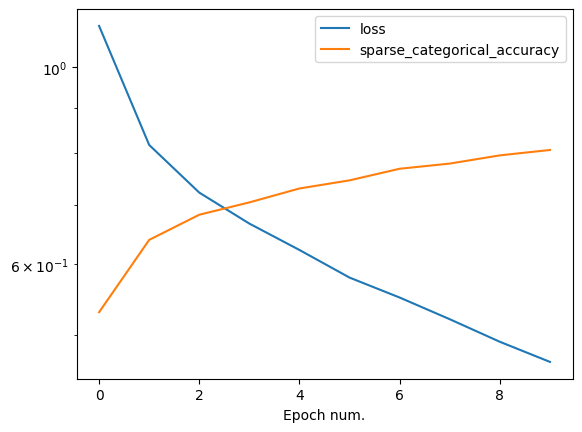

In [34]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [23]:
datos = pd.read_csv('/content/mpbd-20232024-stock-sentiments-slam/test.csv')

In [24]:
x_test = tokenizer.texts_to_sequences(datos['headline'])

In [25]:
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index['<pad>'],
    padding='post',
    maxlen=MAX_SEQUENCE_LEN
)

In [39]:
predictiones = model.predict(x_test)

16/16 [==============================] - 0s 5ms/step


In [40]:
predictiones

array([[0.09055569, 0.88405544, 0.23684742],
       [0.02594887, 0.84296733, 0.75498456],
       [0.6367602 , 0.5167561 , 0.50748724],
       ...,
       [0.01872202, 0.9924094 , 0.70715225],
       [0.48490685, 0.82087374, 0.5444676 ],
       [0.27290338, 0.9121051 , 0.55500627]], dtype=float32)

In [41]:
encoded_predictions = predictiones.argmax(axis = -1)

In [42]:
encoded_predictions

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,

In [44]:
datos['sentiment'] = encoded_predictions.tolist()

In [45]:
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")

In [46]:
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,negative
3,Starbucks Shares Tick Lower On Slow Growth Rep...,neutral
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [ ]:
datos.to_csv('resultado_test.csv', index = False)

## CREAMOS SEGUNDA RED NEURONAL

In [48]:
model2 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),  # Agregar otra capa de convolución
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Aumentar el número de unidades en la capa densa
    tf.keras.layers.Dropout(0.5),  # Agregar dropout para regularización
    tf.keras.layers.Dense(3, activation='softmax')  # Cambiar la función de activación a softmax para salida de clasificación múltiple
])

# Compilar el modelo
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Ajustar la tasa de aprendizaje
    metrics=['sparse_categorical_accuracy'],
)

# Resumen del modelo
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 32, 50)            506750    
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 32)            8032      
                                                                 
 batch_normalization_3 (Bat  (None, 28, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 batch_normalization_4 (Bat  (None, 24, 64)            256       
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1536)             

In [49]:
history2 = model2.fit(x_train, y_train, epochs=20)

Epoch 1/20
152/152 [==============================] - 4s 11ms/step - loss: 1.1482 - sparse_categorical_accuracy: 0.5550
Epoch 2/20
152/152 [==============================] - 1s 8ms/step - loss: 0.7333 - sparse_categorical_accuracy: 0.6827
Epoch 3/20
152/152 [==============================] - 1s 8ms/step - loss: 0.5717 - sparse_categorical_accuracy: 0.7540
Epoch 4/20
152/152 [==============================] - 1s 8ms/step - loss: 0.4608 - sparse_categorical_accuracy: 0.8115
Epoch 5/20
152/152 [==============================] - 1s 8ms/step - loss: 0.3847 - sparse_categorical_accuracy: 0.8456
Epoch 6/20
152/152 [==============================] - 1s 9ms/step - loss: 0.3510 - sparse_categorical_accuracy: 0.8640
Epoch 7/20
152/152 [==============================] - 1s 9ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.8940
Epoch 8/20
152/152 [==============================] - 1s 10ms/step - loss: 0.2289 - sparse_categorical_accuracy: 0.9138
Epoch 9/20
152/152 [==========================

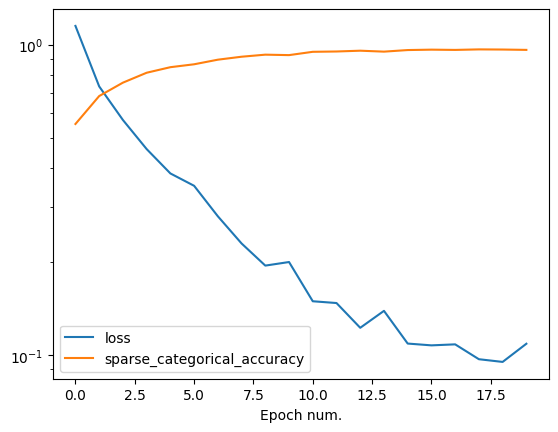

In [50]:
pd.DataFrame(history2.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [52]:
predicciones2 = model2.predict(x_test)

16/16 [==============================] - 0s 3ms/step


In [54]:
encoded_predicciones2 = predicciones2.argmax(axis = -1)

In [55]:
datos['sentiment'] = encoded_predicciones2.tolist()

In [57]:
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")

In [58]:
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [59]:
datos.to_csv('resultado_test.csv', index = False)

## TERCERA RED NEURONAL

In [60]:
model3 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),  # Agregar otra capa de convolución
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Aumentar el número de unidades en la capa densa
    tf.keras.layers.Dense(3, activation='sigmoid')  # Cambiar la función de activación a softmax para salida de clasificación múltiple
])

# Compilar el modelo
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Ajustar la tasa de aprendizaje
    metrics=['sparse_categorical_accuracy'],
)

# Resumen del modelo
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 32, 50)            506750    
                                                                 
 conv1d_5 (Conv1D)           (None, 28, 32)            8032      
                                                                 
 batch_normalization_5 (Bat  (None, 28, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 batch_normalization_6 (Bat  (None, 24, 64)            256       
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 1536)             

In [61]:
history3 = model3.fit(x_train, y_train, epochs=30)

Epoch 1/30
152/152 [==============================] - 3s 8ms/step - loss: 0.9771 - sparse_categorical_accuracy: 0.5938
Epoch 2/30
152/152 [==============================] - 2s 10ms/step - loss: 0.5154 - sparse_categorical_accuracy: 0.7908
Epoch 3/30
152/152 [==============================] - 2s 14ms/step - loss: 0.3294 - sparse_categorical_accuracy: 0.8760
Epoch 4/30
152/152 [==============================] - 2s 14ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9378
Epoch 5/30
152/152 [==============================] - 2s 15ms/step - loss: 0.1146 - sparse_categorical_accuracy: 0.9669
Epoch 6/30
152/152 [==============================] - 2s 15ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9545
Epoch 7/30
152/152 [==============================] - 2s 15ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9626
Epoch 8/30
152/152 [==============================] - 2s 15ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9872
Epoch 9/30
152/152 [=====================

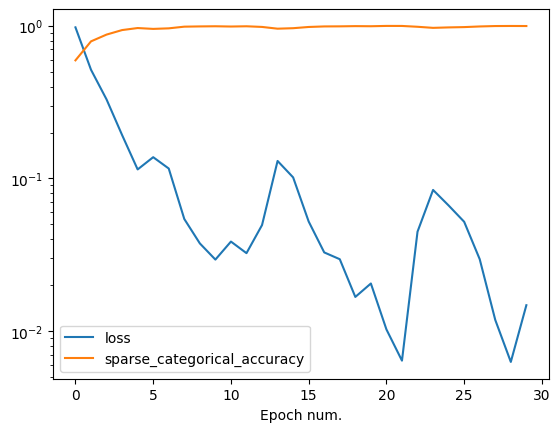

In [62]:
pd.DataFrame(history3.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [63]:
predicciones3 = model3.predict(x_test)

16/16 [==============================] - 1s 10ms/step


In [64]:
encoded_predicciones3 = predicciones3.argmax(axis = -1)

In [65]:
datos['sentiment'] = encoded_predicciones3.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,positive
3,Starbucks Shares Tick Lower On Slow Growth Rep...,positive
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [66]:
datos.to_csv('resultado_test.csv', index = False)

##CUARTO MODELO RNN

In [29]:
model4 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 lstm_1 (LSTM)               (None, 32, 16)            4288      
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 512577 (1.96 MB)
Trainable params: 5827 (22.76 KB)
Non-trainable params: 506750 (1.93 MB)
_________________________________________________________________


In [30]:
history4 = model4.fit(x_train, y_train, epochs=30)

Epoch 1/30
152/152 [==============================] - 6s 9ms/step - loss: 0.8450 - sparse_categorical_accuracy: 0.6238
Epoch 2/30
152/152 [==============================] - 1s 9ms/step - loss: 0.7457 - sparse_categorical_accuracy: 0.6633
Epoch 3/30
152/152 [==============================] - 1s 8ms/step - loss: 0.6950 - sparse_categorical_accuracy: 0.6881
Epoch 4/30
152/152 [==============================] - 1s 10ms/step - loss: 0.6548 - sparse_categorical_accuracy: 0.7160
Epoch 5/30
152/152 [==============================] - 2s 11ms/step - loss: 0.6226 - sparse_categorical_accuracy: 0.7278
Epoch 6/30
152/152 [==============================] - 2s 10ms/step - loss: 0.5963 - sparse_categorical_accuracy: 0.7427
Epoch 7/30
152/152 [==============================] - 2s 10ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7569
Epoch 8/30
152/152 [==============================] - 1s 10ms/step - loss: 0.5469 - sparse_categorical_accuracy: 0.7658
Epoch 9/30
152/152 [=======================

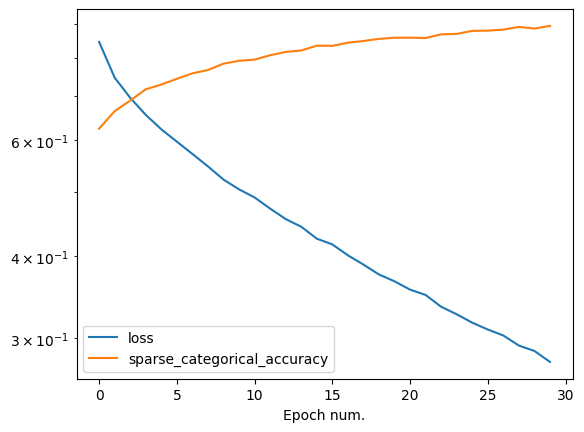

In [31]:
pd.DataFrame(history4.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [32]:
predicciones4 = model4.predict(x_test)

16/16 [==============================] - 1s 2ms/step


In [33]:
encoded_predicciones4 = predicciones4.argmax(axis = -1)

In [34]:
datos['sentiment'] = encoded_predicciones4.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,positive
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [35]:
datos.to_csv('resultado_test.csv', index = False)

## QUINTO MODELO

In [36]:
model5 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(16, return_sequences=True),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 lstm_2 (LSTM)               (None, 32, 16)            4288      
                                                                 
 dropout (Dropout)           (None, 32, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 32)            6272      
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 520385 (1.99 MB)
Trainable params: 13635

In [37]:
history5 = model5.fit(x_train, y_train, epochs=30)

Epoch 1/30
152/152 [==============================] - 6s 8ms/step - loss: 0.8358 - sparse_categorical_accuracy: 0.6279
Epoch 2/30
152/152 [==============================] - 1s 8ms/step - loss: 0.7238 - sparse_categorical_accuracy: 0.6674
Epoch 3/30
152/152 [==============================] - 1s 9ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.6840
Epoch 4/30
152/152 [==============================] - 2s 11ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.6999
Epoch 5/30
152/152 [==============================] - 2s 12ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.7197
Epoch 6/30
152/152 [==============================] - 2s 12ms/step - loss: 0.6141 - sparse_categorical_accuracy: 0.7241
Epoch 7/30
152/152 [==============================] - 2s 13ms/step - loss: 0.6028 - sparse_categorical_accuracy: 0.7360
Epoch 8/30
152/152 [==============================] - 2s 12ms/step - loss: 0.5782 - sparse_categorical_accuracy: 0.7468
Epoch 9/30
152/152 [=======================

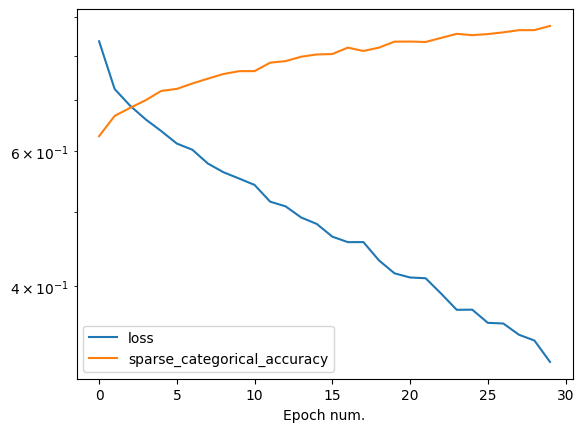

In [38]:
pd.DataFrame(history5.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [39]:
predicciones5 = model5.predict(x_test)

16/16 [==============================] - 1s 5ms/step


In [40]:
encoded_predicciones5 = predicciones5.argmax(axis = -1)

In [41]:
datos['sentiment'] = encoded_predicciones5.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,negative


In [42]:
datos.to_csv('resultado_test.csv', index = False)

## SEXTO MODELO

In [43]:
model6 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),  # Capa densa adicional
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # Utiliza softmax para clasificación multiclase
])

model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 lstm_4 (LSTM)               (None, 32, 32)            10624     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 64)            24832     
                                                                 
 dropout_2 (Dropout)         (None, 32, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [44]:
history6 = model6.fit(x_train, y_train, epochs=30)

Epoch 1/30
152/152 [==============================] - 15s 29ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.6329
Epoch 2/30
152/152 [==============================] - 3s 20ms/step - loss: 0.7181 - sparse_categorical_accuracy: 0.6720
Epoch 3/30
152/152 [==============================] - 2s 16ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.6959
Epoch 4/30
152/152 [==============================] - 4s 23ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7112
Epoch 5/30
152/152 [==============================] - 4s 24ms/step - loss: 0.6019 - sparse_categorical_accuracy: 0.7352
Epoch 6/30
152/152 [==============================] - 4s 25ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.7588
Epoch 7/30
152/152 [==============================] - 3s 18ms/step - loss: 0.5450 - sparse_categorical_accuracy: 0.7722
Epoch 8/30
152/152 [==============================] - 3s 17ms/step - loss: 0.5204 - sparse_categorical_accuracy: 0.7823
Epoch 9/30
152/152 [===================

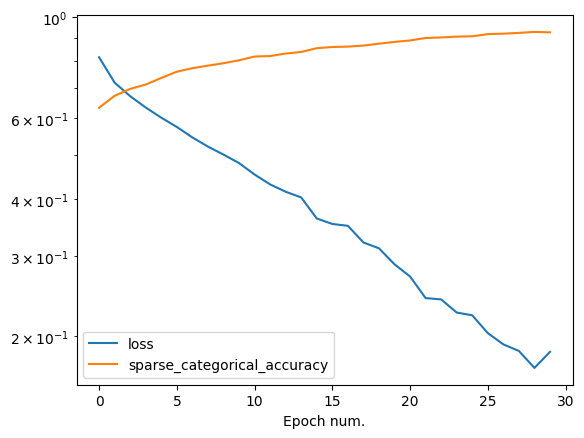

In [45]:
pd.DataFrame(history6.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [46]:
predicciones6 = model6.predict(x_test)

16/16 [==============================] - 1s 6ms/step


In [47]:
encoded_predicciones6 = predicciones6.argmax(axis = -1)

In [48]:
datos['sentiment'] = encoded_predicciones6.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,neutral
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [49]:
datos.to_csv('resultado_test.csv', index = False)

## SEPTIMO MODELO

In [62]:
model7 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(16,activation="relu", return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(32,activation="relu", return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32,activation="relu", return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model7.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 lstm_13 (LSTM)              (None, 32, 16)            4288      
                                                                 
 dropout_10 (Dropout)        (None, 32, 16)            0         
                                                                 
 lstm_14 (LSTM)              (None, 32, 32)            6272      
                                                                 
 dropout_11 (Dropout)        (None, 32, 32)            0         
                                                                 
 lstm_15 (LSTM)              (None, 32, 32)            8320      
                                                                 
 flatten_11 (Flatten)        (None, 1024)            

In [63]:
history7 = model7.fit(x_train, y_train, epochs=30)

Epoch 1/30
152/152 [==============================] - 45s 265ms/step - loss: 0.8630 - sparse_categorical_accuracy: 0.6180
Epoch 2/30
152/152 [==============================] - 28s 184ms/step - loss: 0.7713 - sparse_categorical_accuracy: 0.6604
Epoch 3/30
152/152 [==============================] - 28s 184ms/step - loss: 0.7477 - sparse_categorical_accuracy: 0.6631
Epoch 4/30
152/152 [==============================] - 29s 193ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.6614
Epoch 5/30
152/152 [==============================] - 44s 291ms/step - loss: 0.6983 - sparse_categorical_accuracy: 0.6728
Epoch 6/30
152/152 [==============================] - 32s 207ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.6767
Epoch 7/30
152/152 [==============================] - 32s 208ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.6906
Epoch 8/30
152/152 [==============================] - 30s 196ms/step - loss: 0.6459 - sparse_categorical_accuracy: 0.7061
Epoch 9/30
152/152 [====

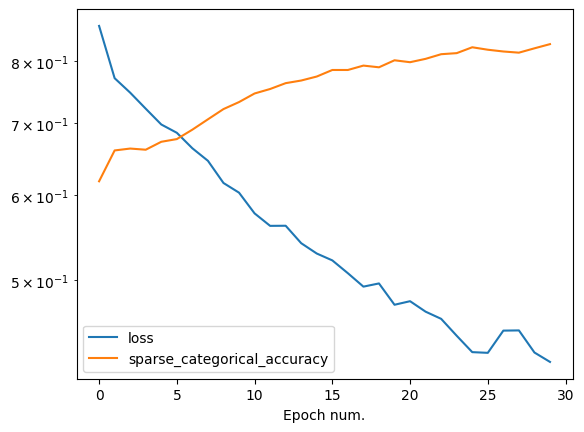

In [64]:
pd.DataFrame(history7.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [65]:
predicciones7 = model7.predict(x_test)

16/16 [==============================] - 1s 29ms/step


In [66]:
encoded_predicciones7 = predicciones7.argmax(axis = -1)

In [67]:
datos['sentiment'] = encoded_predicciones7.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [68]:
datos.to_csv('resultado_test.csv', index = False)

## OCTAVO MODELO

In [69]:
model8 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(16, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model8.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model8.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 conv1d_6 (Conv1D)           (None, 28, 16)            4016      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 14, 16)            0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 16)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 32)            2592      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 32)             0         
 g1D)                                                

In [74]:
history8 = model8.fit(x_train, y_train, epochs=50)

Epoch 1/50
152/152 [==============================] - 1s 7ms/step - loss: 0.5239 - sparse_categorical_accuracy: 0.7792
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.5131 - sparse_categorical_accuracy: 0.7828
Epoch 3/50
152/152 [==============================] - 1s 4ms/step - loss: 0.5035 - sparse_categorical_accuracy: 0.7840
Epoch 4/50
152/152 [==============================] - 1s 4ms/step - loss: 0.4937 - sparse_categorical_accuracy: 0.7966
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.4959 - sparse_categorical_accuracy: 0.7921
Epoch 6/50
152/152 [==============================] - 1s 4ms/step - loss: 0.4993 - sparse_categorical_accuracy: 0.7958
Epoch 7/50
152/152 [==============================] - 1s 4ms/step - loss: 0.4942 - sparse_categorical_accuracy: 0.7894
Epoch 8/50
152/152 [==============================] - 1s 4ms/step - loss: 0.4995 - sparse_categorical_accuracy: 0.7894
Epoch 9/50
152/152 [============================

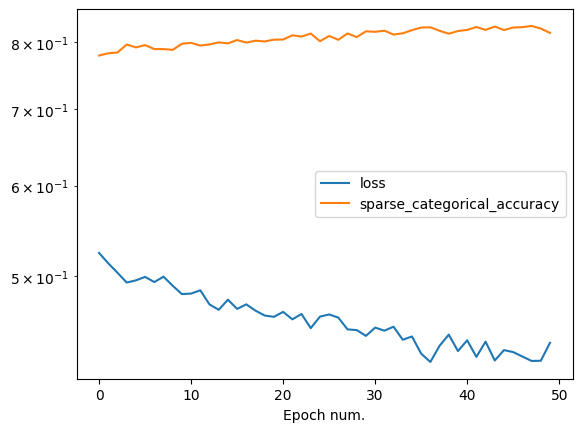

In [75]:
pd.DataFrame(history8.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [73]:
predicciones8 = model8.predict(x_test)

16/16 [==============================] - 0s 10ms/step


In [76]:
encoded_predicciones8 = predicciones8.argmax(axis = -1)

In [77]:
datos['sentiment'] = encoded_predicciones8.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,positive
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [78]:
datos.to_csv('resultado_test.csv', index = False)

## NOVENO MODELO

In [79]:
model9 = tf.keras.models.Sequential([
    embedding_layer,
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model9.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

model9.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       multiple                  506750    
                                                                 
 conv1d_8 (Conv1D)           (None, 30, 16)            2416      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 16)            0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 15, 16)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 13, 32)            1568      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 6, 32)             0         
 g1D)                                                

In [80]:
history9 = model9.fit(x_train, y_train, epochs=70)

Epoch 1/70
152/152 [==============================] - 5s 8ms/step - loss: 0.9350 - sparse_categorical_accuracy: 0.5690
Epoch 2/70
152/152 [==============================] - 1s 7ms/step - loss: 0.8555 - sparse_categorical_accuracy: 0.6126
Epoch 3/70
152/152 [==============================] - 1s 7ms/step - loss: 0.8178 - sparse_categorical_accuracy: 0.6333
Epoch 4/70
152/152 [==============================] - 1s 7ms/step - loss: 0.7881 - sparse_categorical_accuracy: 0.6439
Epoch 5/70
152/152 [==============================] - 1s 7ms/step - loss: 0.7569 - sparse_categorical_accuracy: 0.6647
Epoch 6/70
152/152 [==============================] - 1s 7ms/step - loss: 0.7431 - sparse_categorical_accuracy: 0.6689
Epoch 7/70
152/152 [==============================] - 1s 6ms/step - loss: 0.7281 - sparse_categorical_accuracy: 0.6771
Epoch 8/70
152/152 [==============================] - 1s 7ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.6833
Epoch 9/70
152/152 [============================

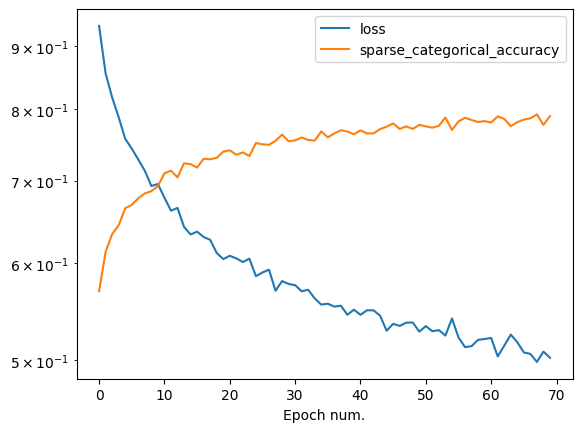

In [81]:
pd.DataFrame(history9.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

In [82]:
predicciones9 = model9.predict(x_test)

16/16 [==============================] - 0s 10ms/step


In [83]:
encoded_predicciones9 = predicciones9.argmax(axis = -1)

In [84]:
datos['sentiment'] = encoded_predicciones9.tolist()
datos['sentiment'] = datos['sentiment'].replace(0,"negative")
datos['sentiment'] = datos['sentiment'].replace(1,"neutral")
datos['sentiment'] = datos['sentiment'].replace(2,"positive")
datos

,headline,sentiment
0,Macquarie Downgrades Information Services to N...,neutral
1,Summit Midstream started with Buy at Janney on...,neutral
2,India Globalization Capital Increases Iron Ore...,neutral
3,Starbucks Shares Tick Lower On Slow Growth Rep...,negative
4,Xtera Initiates Legal Action against Nokia and...,neutral
...,...,...
495,William Blair Downgrades Illumina to Market Pe...,neutral
496,Strongbow Files Technical Report and Resource ...,neutral
497,A Conversation With A Former Hedge Fund Analys...,neutral
498,Progressive Refunds Premium to Members on Redu...,neutral


In [85]:
datos.to_csv('resultado_test.csv', index = False)